In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sys import getsizeof
%matplotlib inline

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix, mean_squared_error
import xgboost as xgb
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# DataBase exploration and cleaning

In [3]:
df = pd.read_excel('incidents from 2012.xlsx', skiprows=5)

In [4]:
df.head(3)

,Номер инцидента,Статус,Заявитель,Классификатор,Категория,Описание,Последний комментарий,Дата регистрации,Unnamed: 8,Закрыт,Департамент,Назначенная группа,Назначенный специалист,Вложений
0,1565301,Закрыт,Воеводкин Олег Евгеньевич,SAP,Прочее,[voevodkin.oleg] Описание: Прошу разблокироват...,"Разблокировал. Пароль сбросил на 123456. Олег,...",2012-01-04 12:32:51.917,NaN,2012-01-04 15:10:19.100,IT,IT_ERP_SAP,Маюков Павел Валериевич,0
1,1565520,Закрыт,Васильева Наталья Александровна_del,SAP,Прочее,прошу сменить пароль на вход в систему SAP;IP:...,Разблокировал. Пароль сброшен на 123456.,2012-01-04 13:30:19.487,NaN,2012-01-04 15:14:36.030,IT,IT_ERP_SAP,Маюков Павел Валериевич,0
2,1566472,Закрыт,Чупрунов Александр Александрович,SAP,Обучение/консультация,[chuprunov.aleksandr] Описание: При набивании ...,"В момент ручного заполнения полей в САП, систе...",2012-01-04 16:21:38.673,NaN,2012-01-04 16:42:32.130,IT,IT_ERP_SAP,Дубровин Денис Владимирович,0


In [5]:
df['Unnamed: 8'].unique()

array([ nan])

In [6]:
df.head(3)

,Номер инцидента,Статус,Заявитель,Классификатор,Категория,Описание,Последний комментарий,Дата регистрации,Unnamed: 8,Закрыт,Департамент,Назначенная группа,Назначенный специалист,Вложений
0,1565301,Закрыт,Воеводкин Олег Евгеньевич,SAP,Прочее,[voevodkin.oleg] Описание: Прошу разблокироват...,"Разблокировал. Пароль сбросил на 123456. Олег,...",2012-01-04 12:32:51.917,NaN,2012-01-04 15:10:19.100,IT,IT_ERP_SAP,Маюков Павел Валериевич,0
1,1565520,Закрыт,Васильева Наталья Александровна_del,SAP,Прочее,прошу сменить пароль на вход в систему SAP;IP:...,Разблокировал. Пароль сброшен на 123456.,2012-01-04 13:30:19.487,NaN,2012-01-04 15:14:36.030,IT,IT_ERP_SAP,Маюков Павел Валериевич,0
2,1566472,Закрыт,Чупрунов Александр Александрович,SAP,Обучение/консультация,[chuprunov.aleksandr] Описание: При набивании ...,"В момент ручного заполнения полей в САП, систе...",2012-01-04 16:21:38.673,NaN,2012-01-04 16:42:32.130,IT,IT_ERP_SAP,Дубровин Денис Владимирович,0


In [7]:
df = df.drop(['Статус', 'Unnamed: 8', 'Департамент'], axis=1)

In [8]:
df.columns = ['incident_id', 'applicant', 'classifier', 'category', 'description', 'comment', \
              'opened', 'closed', 'support_group', 'specialist', 'attachments']

In [9]:
df.head(3)

,incident_id,applicant,classifier,category,description,comment,opened,closed,support_group,specialist,attachments
0,1565301,Воеводкин Олег Евгеньевич,SAP,Прочее,[voevodkin.oleg] Описание: Прошу разблокироват...,"Разблокировал. Пароль сбросил на 123456. Олег,...",2012-01-04 12:32:51.917,2012-01-04 15:10:19.100,IT_ERP_SAP,Маюков Павел Валериевич,0
1,1565520,Васильева Наталья Александровна_del,SAP,Прочее,прошу сменить пароль на вход в систему SAP;IP:...,Разблокировал. Пароль сброшен на 123456.,2012-01-04 13:30:19.487,2012-01-04 15:14:36.030,IT_ERP_SAP,Маюков Павел Валериевич,0
2,1566472,Чупрунов Александр Александрович,SAP,Обучение/консультация,[chuprunov.aleksandr] Описание: При набивании ...,"В момент ручного заполнения полей в САП, систе...",2012-01-04 16:21:38.673,2012-01-04 16:42:32.130,IT_ERP_SAP,Дубровин Денис Владимирович,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32079 entries, 0 to 32078
Data columns (total 11 columns):
incident_id      32079 non-null int64
applicant        32073 non-null object
classifier       32079 non-null object
category         32079 non-null object
description      32079 non-null object
comment          31960 non-null object
opened           32079 non-null datetime64[ns]
closed           32079 non-null datetime64[ns]
support_group    32079 non-null object
specialist       28241 non-null object
attachments      32079 non-null int64
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 2.7+ MB


In [11]:
df.describe()

,incident_id,attachments
count,3.207900e+04,32079.000000
mean,7.292592e+06,0.230836
std,2.759946e+06,0.612688
min,1.565301e+06,0.000000
25%,5.153027e+06,0.000000
50%,7.867202e+06,0.000000
75%,9.539087e+06,0.000000
max,1.169513e+07,18.000000


In [12]:
df_length = df.shape[0]

In [13]:
df_length

32079

In [14]:
df.classifier.unique()

array(['SAP', 'MDM', 'прочее', 'сист. блок ', '1С', 'Инвентаризация',
       'Код на инвентаризацию', '1С Доступ', 'Установка',
       'Блокировка движения в САП', 'Assyst', 'ОЛАП',
       'Запрос пакета документов по аренде', 'Неверная цена', 'MDM Доступ',
       '1С УСО', 'Hyperion (Аренда, Ритейл)', 'BI', 'Проблемы с ТСД', 'ТБ',
       'Продажа', '1С АКТИВАЦИЯ', 'не отображаются страницы',
       'Расхождение (z-отчет-ЛП)', 'Исправление отрицательных остатков',
       'ЭКВАЙРИНГ', 'Возврат', 'Расхождение при приёмке товара со Склада',
       'Перемещение товара', 'Пересчёт товара по расхождениям',
       'Отсутствие инфо-записи в SAP', 'Сетевые папки',
       'ЦСХ  Прием товара',
       'Отчеты по выполнению планов (все направления)', 'ФБ',
       'Описание для ERP', 'Некорректная поставка в SAP',
       'Нет расходной накладной с ОП в SAP', 'VPN', 'Web-отчёты', 'НСИ',
       'ЦБ', 'открыть доступ во внешнюю сеть', 'IP телефон ', 'Отчеты',
       'Портал', 'По Достаточности', 'Рассы

In [15]:
df.classifier.unique().size

94

In [16]:
df.category.sort_values().unique()

array([' (GSM, Portable, АCC, POSM)', 'Acce', 'BI', 'BI отчеты РТК',
       'FileNet', 'GSM', 'GSM, Portable, ACC, POSM', 'MS Office',
       'OEBS. Ошибки', 'OEBS. Технические проблемы', 'SIM Самара',
       'SIM Сибирь', 'SIM Урал', 'SIM Центр', 'SIM Юг', 'Авария на складе',
       'Анализ новых треб к доработкам', 'Блокировка движения в САП',
       'Внес инф в OEBS о новом покупа', 'Внутрискладские перемещени ТМЦ',
       'Восстановление БД', 'Выгрузить ЛП за опред.дату',
       'Вып. прочих транзакций, исправ', 'Данные не обновлены ',
       'Добавить в сущ группу рассылки', 'Добавление в Набор значений',
       'Договор аренды', 'Доработка Web-форм',
       'Доработка кубов/согл заявки CQ', 'Доработка отчет',
       'Доработка отчета', 'Доработка проектной документац',
       'Доработка расчетов', 'Доработка функциональности', 'Доступ',
       'Доступ 5 и более пользователей', 'Доступ к Web-отчетам msk-repor',
       'Доступ к роли', 'Доступ к сетевым папкам',
       'Доступ к уз

In [17]:
df.category.unique().size

150

In [18]:
df.support_group.unique()

array(['IT_ERP_SAP', 'IT_ERP_MDM', 'IT_ERP_HYPERION', 'IT_ERP_BI',
       'IT_ERP_ESB', 'IT_ERP_POSDM', 'IT_ERP_DWH'], dtype=object)

In [19]:
df.support_group.unique().size

7

In [20]:
df.specialist.unique()

array(['Маюков Павел Валериевич', 'Дубровин Денис Владимирович', nan,
       'Кудряшов Максим Владимирович', 'Изотова Карина Анатольевна',
       'Ковалёв Дмитрий Алексеевич', 'Залетов Владимир Юрьевич',
       'Васин Александр Сергеевич', 'Мастерова Татьяна Владимировна',
       'Севрюков Александр Михайлович', 'Быстрицкая Элина Юрьевна',
       'Кордий Светлана Александровна', 'Шкаирзянова Альбина Владиленовна',
       'Свирин Андрей Васильевич', 'Толстых Денис Александрович',
       'Зангиева Залина Вячеславовна', 'Макаров Илья Николаевич',
       'Богдан Фёдор Сергеевич', 'Рогозин Александр Валерьевич',
       'Шведков Артем Евгеньевич', 'Садиков Иван Игоревич',
       'Ермоленко Александр Николаевич', 'Задорожный Арсений Андреевич',
       'Наумов Андрей Витальевич', 'Грязнов Александр Дмитриевич',
       'Баданин Василий Павлович', 'Репников Евгений Александрович',
       'Дубовой Александр Александрович', '111', 'Алиев Тимур Эркинович',
       'Хомяков Илья Геннадьевич', 'Дорожк

In [21]:
df.specialist.unique().size

55

In [22]:
print(df.opened.min())
print(df.closed.min())
print(df.opened.max())
print(df.closed.max())

2012-01-04 12:32:51.917000
2012-01-04 15:10:19.100000
2017-09-24 17:08:46.610000
2017-09-25 09:11:47.183000


In [23]:
print((df.closed - df.opened).min())
print((df.closed - df.opened).max())

0 days 00:00:09.464000
691 days 03:25:16.993000


In [24]:
type(df.closed[0])

pandas._libs.tslib.Timestamp

In [25]:
def datestr_to_int(s):
    return pd.to_datetime(s).value

In [26]:
one_day = datestr_to_int('2016-09-12') - datestr_to_int('2016-09-11')
one_hour = one_day // 24
print('one day is', one_day)
print('one hour is', one_hour)

one day is 86400000000000
one hour is 3600000000000


In [27]:
df['solve_hours'] = (df.closed - df.opened).map(lambda s: s.value // one_hour)
df['solve_days'] = (df.closed - df.opened).map(lambda s: s.value // one_day)

(array([  2.85340000e+04,   1.43100000e+03,   7.11000000e+02,
          4.34000000e+02,   2.16000000e+02,   1.43000000e+02,
          1.15000000e+02,   8.70000000e+01,   5.00000000e+01,
          4.70000000e+01,   4.40000000e+01,   3.00000000e+01,
          2.40000000e+01,   2.10000000e+01,   1.80000000e+01,
          1.20000000e+01,   1.10000000e+01,   2.70000000e+01,
          8.00000000e+00,   1.30000000e+01,   1.10000000e+01,
          6.00000000e+00,   5.00000000e+00,   7.00000000e+00,
          3.00000000e+00,   5.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          6.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   1.00000000e+00,
        

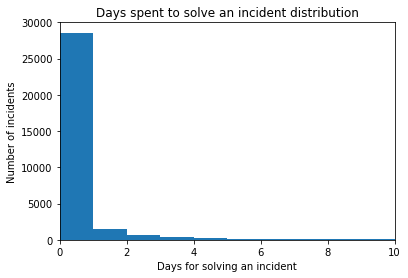

In [28]:
plt.xlabel('Days for solving an incident')
plt.ylabel('Number of incidents')
plt.title('Days spent to solve an incident distribution')
plt.axis([0, 10, 0, 30000])
plt.hist(df.solve_days, bins=691)

(array([  2.11240000e+04,   1.85900000e+03,   1.18800000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]),
 array([  0.00000000e+00,   1.00018090e+00,   2.00036179e+00, ...,
          1.65849996e+04,   1.65859998e+04,   1.65870000e+04]),
 <a list of 16584 Patch objects>)

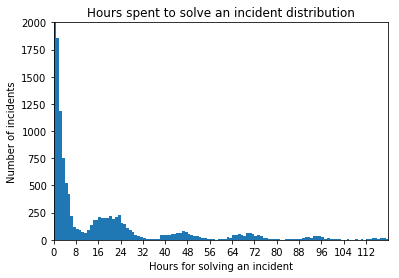

In [29]:
plt.xlabel('Hours for solving an incident')
plt.ylabel('Number of incidents')
plt.title('Hours spent to solve an incident distribution')
plt.axis([0, 5*24, 0, 2000])
plt.xticks(range(0, 5*24, 8))
plt.hist(df.solve_hours, bins=691*24)

In [30]:
df.head(3)

,incident_id,applicant,classifier,category,description,comment,opened,closed,support_group,specialist,attachments,solve_hours,solve_days
0,1565301,Воеводкин Олег Евгеньевич,SAP,Прочее,[voevodkin.oleg] Описание: Прошу разблокироват...,"Разблокировал. Пароль сбросил на 123456. Олег,...",2012-01-04 12:32:51.917,2012-01-04 15:10:19.100,IT_ERP_SAP,Маюков Павел Валериевич,0,2,0
1,1565520,Васильева Наталья Александровна_del,SAP,Прочее,прошу сменить пароль на вход в систему SAP;IP:...,Разблокировал. Пароль сброшен на 123456.,2012-01-04 13:30:19.487,2012-01-04 15:14:36.030,IT_ERP_SAP,Маюков Павел Валериевич,0,1,0
2,1566472,Чупрунов Александр Александрович,SAP,Обучение/консультация,[chuprunov.aleksandr] Описание: При набивании ...,"В момент ручного заполнения полей в САП, систе...",2012-01-04 16:21:38.673,2012-01-04 16:42:32.130,IT_ERP_SAP,Дубровин Денис Владимирович,0,0,0


In [31]:
df.closed.map(lambda s: s.weekday()).describe()
# 0 = Monday, 1 = Tuesday etc.

count    32079.000000
mean         2.036192
std          1.554013
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: closed, dtype: float64

In [32]:
df['opened_year'] = df.opened.map(lambda s: s.year)
df['opened_month'] = df.opened.map(lambda s: s.month)
df['opened_day'] = df.opened.map(lambda s: s.day)

In [33]:
df['opened_weekday'] = df.opened.map(lambda s: s.weekday())
df['closed_weekday'] = df.closed.map(lambda s: s.weekday())

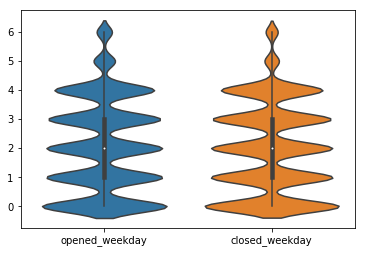

In [34]:
sns.violinplot(data=df[['opened_weekday', 'closed_weekday']])

In [35]:
df.head(3)

,incident_id,applicant,classifier,category,description,comment,opened,closed,support_group,specialist,attachments,solve_hours,solve_days,opened_year,opened_month,opened_day,opened_weekday,closed_weekday
0,1565301,Воеводкин Олег Евгеньевич,SAP,Прочее,[voevodkin.oleg] Описание: Прошу разблокироват...,"Разблокировал. Пароль сбросил на 123456. Олег,...",2012-01-04 12:32:51.917,2012-01-04 15:10:19.100,IT_ERP_SAP,Маюков Павел Валериевич,0,2,0,2012,1,4,2,2
1,1565520,Васильева Наталья Александровна_del,SAP,Прочее,прошу сменить пароль на вход в систему SAP;IP:...,Разблокировал. Пароль сброшен на 123456.,2012-01-04 13:30:19.487,2012-01-04 15:14:36.030,IT_ERP_SAP,Маюков Павел Валериевич,0,1,0,2012,1,4,2,2
2,1566472,Чупрунов Александр Александрович,SAP,Обучение/консультация,[chuprunov.aleksandr] Описание: При набивании ...,"В момент ручного заполнения полей в САП, систе...",2012-01-04 16:21:38.673,2012-01-04 16:42:32.130,IT_ERP_SAP,Дубровин Денис Владимирович,0,0,0,2012,1,4,2,2


In [36]:
df.groupby('comment').count().sort_values(by='incident_id', ascending=False).head(20)

,incident_id,applicant,classifier,category,description,opened,closed,support_group,specialist,attachments,solve_hours,solve_days,opened_year,opened_month,opened_day,opened_weekday,closed_weekday
comment,,,,,,,,,,,,,,,,,
РЕШЕНО/0<br/>Решено,1256,1256,1256,1256,1256,1256,1256,1256,1137,1256,1256,1256,1256,1256,1256,1256,1256
Статус присвоен.,1148,1148,1148,1148,1148,1148,1148,1148,1103,1148,1148,1148,1148,1148,1148,1148,1148
Лист продаж выгружен,1083,1083,1083,1083,1083,1083,1083,1083,1078,1083,1083,1083,1083,1083,1083,1083,1083
РЕШЕНО/0<br/>Статус присвоен,572,572,572,572,572,572,572,572,568,572,572,572,572,572,572,572,572
готово,571,571,571,571,571,571,571,571,516,571,571,571,571,571,571,571,571
Материал расширен.,570,570,570,570,570,570,570,570,521,570,570,570,570,570,570,570,570
Исправлено.,496,496,496,496,496,496,496,496,461,496,496,496,496,496,496,496,496
"Лист продаж выгружен, автовыгрузка налажена",430,430,430,430,430,430,430,430,430,430,430,430,430,430,430,430,430
"РЕШЕНО/0<br/>Лист продаж выгружен, автовыгрузка налажена",420,420,420,420,420,420,420,420,420,420,420,420,420,420,420,420,420


In [37]:
df = df.drop('comment', axis=1)

In [38]:
df.head(3)

,incident_id,applicant,classifier,category,description,opened,closed,support_group,specialist,attachments,solve_hours,solve_days,opened_year,opened_month,opened_day,opened_weekday,closed_weekday
0,1565301,Воеводкин Олег Евгеньевич,SAP,Прочее,[voevodkin.oleg] Описание: Прошу разблокироват...,2012-01-04 12:32:51.917,2012-01-04 15:10:19.100,IT_ERP_SAP,Маюков Павел Валериевич,0,2,0,2012,1,4,2,2
1,1565520,Васильева Наталья Александровна_del,SAP,Прочее,прошу сменить пароль на вход в систему SAP;IP:...,2012-01-04 13:30:19.487,2012-01-04 15:14:36.030,IT_ERP_SAP,Маюков Павел Валериевич,0,1,0,2012,1,4,2,2
2,1566472,Чупрунов Александр Александрович,SAP,Обучение/консультация,[chuprunov.aleksandr] Описание: При набивании ...,2012-01-04 16:21:38.673,2012-01-04 16:42:32.130,IT_ERP_SAP,Дубровин Денис Владимирович,0,0,0,2012,1,4,2,2


# Creating Features and Labels DataSets

In [39]:
# database for ML withOUT 'description'
df1 = df.drop(['incident_id', 'description', 'opened', 'closed', 'support_group', 'specialist', 'solve_hours', 'solve_days', 'closed_weekday'], axis=1)

In [40]:
df1.head(3)

,applicant,classifier,category,attachments,opened_year,opened_month,opened_day,opened_weekday
0,Воеводкин Олег Евгеньевич,SAP,Прочее,0,2012,1,4,2
1,Васильева Наталья Александровна_del,SAP,Прочее,0,2012,1,4,2
2,Чупрунов Александр Александрович,SAP,Обучение/консультация,0,2012,1,4,2


In [41]:
# nice peace of code
df.applicant[['_' in s for s in df.applicant.astype(dtype='str')]].head()

1      Васильева Наталья Александровна_del
43          Бобкова Ольга Владимировна_del
55          Бобкова Ольга Владимировна_del
80            Реутенко Юлия Викторовна_del
160       Александрова Анна Витальевна_del
Name: applicant, dtype: object

In [42]:
df1.head(3)

,applicant,classifier,category,attachments,opened_year,opened_month,opened_day,opened_weekday
0,Воеводкин Олег Евгеньевич,SAP,Прочее,0,2012,1,4,2
1,Васильева Наталья Александровна_del,SAP,Прочее,0,2012,1,4,2
2,Чупрунов Александр Александрович,SAP,Обучение/консультация,0,2012,1,4,2


In [43]:
df1['opened_weekday'] = pd.Categorical(df1['opened_weekday'])
df1['opened_year'] = pd.Categorical(df1['opened_year'])
df1['opened_month'] = pd.Categorical(df1['opened_month'])
df1['opened_day'] = pd.Categorical(df1['opened_day'])

In [44]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32079 entries, 0 to 32078
Data columns (total 8 columns):
applicant         32073 non-null object
classifier        32079 non-null object
category          32079 non-null object
attachments       32079 non-null int64
opened_year       32079 non-null category
opened_month      32079 non-null category
opened_day        32079 non-null category
opened_weekday    32079 non-null category
dtypes: category(4), int64(1), object(3)
memory usage: 1.1+ MB


In [45]:
df1_dummy_columns = ['applicant', 'classifier', 'category', 'opened_weekday', 'opened_year', 'opened_month', 'opened_day']

In [46]:
df1 = pd.concat([df1['attachments'], pd.get_dummies(df1[df1_dummy_columns], prefix_sep='_', dummy_na=True)], axis=1)

In [47]:
df1.shape

(32079, 2784)

In [48]:
# the function left only columns with at least n non-null elements
def filter_columns(dataframe, n):
    columns = [column for column in dataframe if dataframe[column].sum() >= n]
    return dataframe[columns]

In [49]:
# experiments with a code of the 'filter_columns' function to get it work fast
start_time = time.time()
print(filter_columns(df1, 4).shape)
print(time.time() - start_time)

(32079, 886)
0.9707636833190918


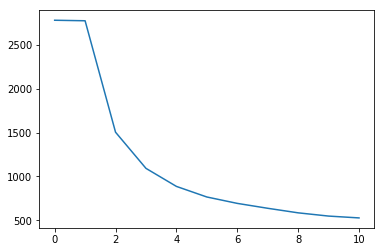

In [50]:
# nice peace of code
plt.plot([filter_columns(df1, i).shape[1] for i in range(11)])

In [51]:
X = filter_columns(df1, 320)

In [52]:
feature_names = X.columns

In [53]:
# all columns are numerical
X.shape[1] == np.sum(X.dtypes == 'int64') + np.sum(X.dtypes == 'uint8')

True

In [54]:
X = StandardScaler().fit_transform(X)

In [55]:
X[:3, :10]

array([[-0.37676585, -0.12141158, -0.11656126, -0.12518983, -0.10303809,
        -0.12376946, -0.13353519, -0.24795247, -0.12272677, -0.10802135],
       [-0.37676585, -0.12141158, -0.11656126, -0.12518983, -0.10303809,
        -0.12376946, -0.13353519, -0.24795247, -0.12272677, -0.10802135],
       [-0.37676585, -0.12141158, -0.11656126, -0.12518983, -0.10303809,
        -0.12376946, -0.13353519, -0.24795247, -0.12272677, -0.10802135]])

In [56]:
X.shape

(32079, 83)

In [57]:
# column 'support_group' has no NaN
sum(df.support_group.isnull())

0

In [58]:
# forming the labels vector
# firstly changing 'object' to 'category'
y = df.support_group.astype('category')

In [59]:
print(y.tail(20))

32059    IT_ERP_SAP
32060    IT_ERP_MDM
32061    IT_ERP_SAP
32062    IT_ERP_SAP
32063    IT_ERP_SAP
32064    IT_ERP_SAP
32065    IT_ERP_SAP
32066     IT_ERP_BI
32067    IT_ERP_DWH
32068    IT_ERP_SAP
32069    IT_ERP_SAP
32070    IT_ERP_SAP
32071    IT_ERP_SAP
32072    IT_ERP_SAP
32073    IT_ERP_SAP
32074    IT_ERP_SAP
32075    IT_ERP_SAP
32076    IT_ERP_SAP
32077    IT_ERP_SAP
32078    IT_ERP_SAP
Name: support_group, dtype: category
Categories (7, object): [IT_ERP_BI, IT_ERP_DWH, IT_ERP_ESB, IT_ERP_HYPERION, IT_ERP_MDM, IT_ERP_POSDM, IT_ERP_SAP]


In [60]:
# replaces categories names to codes from 0 to 6
y = np.array(y.cat.codes)

In [61]:
# check by comparison with a list of names above
print(y[-20:])

[6 4 6 6 6 6 6 0 1 6 6 6 6 6 6 6 6 6 6 6]


# Predicting 'Назначенная группа' with SVC

In [62]:
# choosing support vector classifier with standard parameters
cls_svc = SVC()

In [63]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=123, shuffle=True, stratify=y)

In [64]:
start_time = time.time()
cls_svc.fit(X_tr, y_tr)
print(time.time() - start_time)

13.632062911987305


In [65]:
y_pr = cls_svc.predict(X_te)

In [66]:
support_group_categories = df.support_group.astype('category').cat.categories
print(classification_report(y_te, y_pr, target_names=support_group_categories))

                 precision    recall  f1-score   support

      IT_ERP_BI       0.98      0.97      0.97      1879
     IT_ERP_DWH       0.91      0.66      0.76       122
     IT_ERP_ESB       0.89      0.28      0.42        86
IT_ERP_HYPERION       0.00      0.00      0.00        31
     IT_ERP_MDM       0.00      0.00      0.00        18
   IT_ERP_POSDM       0.00      0.00      0.00         2
     IT_ERP_SAP       0.97      1.00      0.98      5882

    avg / total       0.96      0.97      0.97      8020



C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
pd.DataFrame(confusion_matrix(y_te, y_pr, labels=range(support_group_categories.shape[0])), \
             columns=support_group_categories, index=support_group_categories)

,IT_ERP_BI,IT_ERP_DWH,IT_ERP_ESB,IT_ERP_HYPERION,IT_ERP_MDM,IT_ERP_POSDM,IT_ERP_SAP
IT_ERP_BI,1819,1,1,0,0,0,58
IT_ERP_DWH,10,80,0,0,0,0,32
IT_ERP_ESB,22,0,24,0,0,0,40
IT_ERP_HYPERION,3,0,0,0,0,0,28
IT_ERP_MDM,0,0,0,0,0,0,18
IT_ERP_POSDM,0,0,0,0,0,0,2
IT_ERP_SAP,8,7,2,0,0,0,5865


In [68]:
# the same with linear kernel
# only linear kernel let you extract feature importance from a model
cls_svc = SVC(kernel='linear')

In [69]:
start_time = time.time()
cls_svc.fit(X_tr, y_tr)
print(time.time() - start_time)

11.930479764938354


In [70]:
y_pr = cls_svc.predict(X_te)

In [71]:
support_group_categories = df.support_group.astype('category').cat.categories
print(classification_report(y_te, y_pr, target_names=support_group_categories))

                 precision    recall  f1-score   support

      IT_ERP_BI       0.98      0.97      0.97      1879
     IT_ERP_DWH       0.91      0.66      0.76       122
     IT_ERP_ESB       0.56      0.33      0.41        86
IT_ERP_HYPERION       0.52      0.42      0.46        31
     IT_ERP_MDM       0.00      0.00      0.00        18
   IT_ERP_POSDM       0.00      0.00      0.00         2
     IT_ERP_SAP       0.98      0.99      0.98      5882

    avg / total       0.97      0.97      0.97      8020



C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [72]:
pd.DataFrame(confusion_matrix(y_te, y_pr, labels=range(support_group_categories.shape[0])), \
             columns=support_group_categories, index=support_group_categories)

,IT_ERP_BI,IT_ERP_DWH,IT_ERP_ESB,IT_ERP_HYPERION,IT_ERP_MDM,IT_ERP_POSDM,IT_ERP_SAP
IT_ERP_BI,1817,1,2,3,0,1,55
IT_ERP_DWH,10,80,0,0,0,0,32
IT_ERP_ESB,24,0,28,2,0,0,32
IT_ERP_HYPERION,4,0,3,13,0,0,11
IT_ERP_MDM,0,0,2,0,0,0,16
IT_ERP_POSDM,0,0,0,0,0,0,2
IT_ERP_SAP,8,7,15,7,0,0,5845


In [73]:
# sorting features by importance
# plotting n most important features
def f_importances(coef, names, n):
    imp = np.abs(np.mean(coef, axis=0))
    imp, names = zip(*sorted(zip(imp, names)))
    plt.barh(range(n), imp[-n:], align='center')
    plt.yticks(range(n), names[-n:])
    plt.savefig('svc_features_importance', dpi=600)
    plt.show()

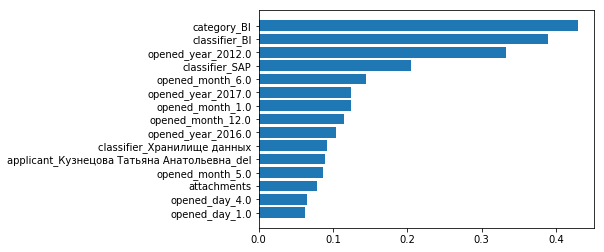

0 sec


In [74]:
start_time = time.time()
f_importances(cls_svc.coef_, feature_names, 15)
print(str(int(time.time() - start_time))+' sec')

# Predicting a time for solving an incident

In [75]:
# 1st attempt is with feature matrix df1 as it was in previous section
# but we aparently make the new classes vector y from df.solve_days
# df.solve_days is of integer type
y = np.array(df.solve_days).astype('float')

In [76]:
X = filter_columns(df1, 3200)

In [77]:
X.shape

(32079, 16)

In [78]:
X = StandardScaler().fit_transform(X)

In [79]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=123, shuffle=True)

In [80]:
# now we use svr, not svc (regressor, not classifier)
cls_svr = SVR(kernel='linear')

In [81]:
start_time = time.time()
cls_svr.fit(X_tr, y_tr)
print(time.time() - start_time)

5.768707275390625


In [82]:
y_pr = cls_svr.predict(X_te)

In [83]:
# firstly MSE = 10 (with X = filter_columns(df1, 320), n_features = 83)
# (14 hours) MSE = 9, precision = 82%, recall = 89% (with X = filter_columns(df1, 3), n_features = 1092)
mean_squared_error(y_te, y_pr)

10.069349798858029

In [84]:
print(classification_report(y_te.astype('int'), y_pr.astype('int')))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94      7159
          1       0.00      0.00      0.00       347
          2       0.00      0.00      0.00       174
          3       0.00      0.00      0.00       103
          4       0.00      0.00      0.00        50
          5       0.00      0.00      0.00        27
          6       0.00      0.00      0.00        29
          7       0.00      0.00      0.00        27
          8       0.00      0.00      0.00         9
          9       0.00      0.00      0.00        10
         10       0.00      0.00      0.00        10
         11       0.00      0.00      0.00        11
         12       0.00      0.00      0.00         6
         13       0.00      0.00      0.00         6
         14       0.00      0.00      0.00         4
         15       0.00      0.00      0.00         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00   

C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# XGBoost Regressor

In [85]:
X = filter_columns(df1, 3)

In [86]:
X.shape

(32079, 1092)

In [87]:
X = StandardScaler().fit_transform(X)

In [88]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=123, shuffle=True)

In [89]:
cls_xgbr = xgb.XGBRegressor(objective='reg:linear', seed=123)

In [90]:
start_time = time.time()
cls_xgbr.fit(X_tr, y_tr)
print(time.time() - start_time)

9.5340416431427


In [91]:
y_pr = cls_xgbr.predict(X_te)

In [92]:
mean_squared_error(y_te, y_pr)

7.7284387031924622

In [93]:
print(classification_report(y_te.astype('int'), y_pr.astype('int')))

             precision    recall  f1-score   support

          0       0.92      0.91      0.92      7159
          1       0.11      0.29      0.16       347
          2       0.08      0.01      0.02       174
          3       0.00      0.00      0.00       103
          4       0.00      0.00      0.00        50
          5       0.00      0.00      0.00        27
          6       0.00      0.00      0.00        29
          7       0.00      0.00      0.00        27
          8       0.00      0.00      0.00         9
          9       0.00      0.00      0.00        10
         10       0.00      0.00      0.00        10
         11       0.00      0.00      0.00        11
         12       0.50      0.17      0.25         6
         13       0.00      0.00      0.00         6
         14       0.00      0.00      0.00         4
         15       0.00      0.00      0.00         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00   

C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [94]:
# fine tuning
xgb_param_grid = {
    'learning_rate': np.arange(0.1, 1.05, 0.15),
    'max_depth': np.arange(2, 5, 1),
    'n_estimators': np.arange(3, 11, 1),
    'colsample_bytree': np.arange(0.1, 1.05, 0.15)
}

In [95]:
#grid_mse = GridSearchCV(estimator=cls_xgbr, param_grid=xgb_param_grid, \
#                        scoring='neg_mean_squared_error', cv=3, verbose=1)

In [96]:
#grid_mse.fit(X, y)

In [97]:
#print(grid_mse.best_score_)
#print(grid_mse.best_estimator_)

In [98]:
cls_xgbr = xgb.XGBRegressor(objective='reg:linear', n_estimators=3, learning_rate=0.85, max_depth=3, colsample_bytree=1, seed=123)

In [99]:
cls_xgbr.fit(X_tr, y_tr)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.85, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=3, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=1)

In [100]:
y_pr = cls_xgbr.predict(X_te)

In [101]:
mean_squared_error(y_te, y_pr)

7.059297885701274

In [102]:
print(classification_report(y_te.astype('int'), y_pr.astype('int')))

             precision    recall  f1-score   support

          0       0.92      0.92      0.92      7159
          1       0.12      0.29      0.16       347
          2       0.00      0.00      0.00       174
          3       0.00      0.00      0.00       103
          4       0.00      0.00      0.00        50
          5       0.00      0.00      0.00        27
          6       0.00      0.00      0.00        29
          7       0.00      0.00      0.00        27
          8       0.00      0.00      0.00         9
          9       0.00      0.00      0.00        10
         10       0.00      0.00      0.00        10
         11       0.00      0.00      0.00        11
         12       0.00      0.00      0.00         6
         13       0.00      0.00      0.00         6
         14       0.00      0.00      0.00         4
         15       0.00      0.00      0.00         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00   

C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Let's apply NLP

In [103]:
# apply NLP to 'description' column
stemmer = RussianStemmer()

In [104]:
class StemTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def stem_string(self, string):
        word_list = word_tokenize(string)
        return " ".join([stemmer.stem(word) for word in word_list])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for i in range(len(X)):
            X[i] = self.stem_string(X[i])
        return X

In [105]:
df2 = pd.read_excel('incidents descriptions stemmed.xlsx')

In [106]:
#start_time = time.time()
#df2 = StemTransformer().fit_transform(df.loc[:, 'description'])
#print(time.time() - start_time)

In [107]:
df2.shape

(32079, 1)

In [108]:
df2.head(3)

,description
0,[ voevodkin.oleg ] описа : прош разблокиров уч...
1,прош смен парол на вход в сист SAP ; IP : ; те...
2,[ chuprunov.aleksandr ] описа : при набива в п...


In [109]:
#df2.to_excel('incidents descriptions stemmed.xlsx')

In [110]:
# list of lower-case descriptions
df2 = [t.lower() for t in df2.description]
print(df2[:3])

['[ voevodkin.oleg ] описа : прош разблокиров учетк павл аркад , горяч алекс и когут валер . ; табельн номер : 000001124 ; em : voevodkin.oleg @ mtsretail.r ; контакт : воеводкин олег евгеньевич ; номер телефон : 11637 ; ip : 192.168.80.110', 'прош смен парол на вход в сист sap ; ip : ; телефон:41984 ;', '[ chuprunov.aleksandr ] описа : при набива в пуст пол знач программ начин тормаз , на кажд букв уход от 5 до 20 секунд , как будт ищет и сравнив напис . пример можн взят заполн логин и парол . ; табельн номер : 000001379 ; em : chuprunov.aleksandr @ mtsretail.r ; контакт : чупрун александр александрович ; номер телефон : 10037 ; ip : 10.143.4.79']


In [111]:
pattern_start = r'\[.+\].*?:\s'

In [112]:
#example 1
re.search(pattern_start, df2[0])

<_sre.SRE_Match object; span=(0, 27), match='[ voevodkin.oleg ] описа : '>

In [113]:
#example 2
re.sub(pattern_start, '', df2[0])

'прош разблокиров учетк павл аркад , горяч алекс и когут валер . ; табельн номер : 000001124 ; em : voevodkin.oleg @ mtsretail.r ; контакт : воеводкин олег евгеньевич ; номер телефон : 11637 ; ip : 192.168.80.110'

In [114]:
df2_cleaned = [re.sub(pattern_start, '', str) for str in df2]

In [115]:
df2_cleaned[:3]

['прош разблокиров учетк павл аркад , горяч алекс и когут валер . ; табельн номер : 000001124 ; em : voevodkin.oleg @ mtsretail.r ; контакт : воеводкин олег евгеньевич ; номер телефон : 11637 ; ip : 192.168.80.110',
 'прош смен парол на вход в сист sap ; ip : ; телефон:41984 ;',
 'при набива в пуст пол знач программ начин тормаз , на кажд букв уход от 5 до 20 секунд , как будт ищет и сравнив напис . пример можн взят заполн логин и парол . ; табельн номер : 000001379 ; em : chuprunov.aleksandr @ mtsretail.r ; контакт : чупрун александр александрович ; номер телефон : 10037 ; ip : 10.143.4.79']

In [116]:
pattern_body = r'(\w+).+?[;<]'

In [117]:
#exapmle
[re.search(pattern_body, str).group(0) for str in df2_cleaned[20500:20505]]

['просьб присво айдок 78 статус из 60 : 0000000100600034 0000000100601272 ;',
 'нет выгрузк дан в интерфейс за 03,01,16 d716 мск бронниц 01 e077 мск варшавск шосс 06 f387 мск волгоградск проспект 04 c759-d501 мск голицын 01 e479 мск дедовск 01 c318-a202 мск дмитр 02 c333-a214 мск егорьевск c336-a217 мск железнодорожн 02 d973 мск землян вал 03 d879 мск измайловск бульвар 01 c493-ai00 мск интернет-магазин f420 мск коровинск шосс 01 c331-a212мск корол 02 <',
 'просьб расшир материа a0307-101905 по завод a199 ;',
 'прош выгруз лп оп u202 за 03,12,2016 в bi и в интерфей. налад автовыгрузк прош направ мо заявк по назначен <',
 'прош по рн 2015p5280001537 от 17.12.2015 измен склад получател на z500 0004 <']

In [118]:
n = 0
result = []
for i in range(len(df2_cleaned)):
    search_result = re.search(pattern_body, df2_cleaned[i])
    if search_result:
        result.append(search_result.group(0))
    else:
        result.append(df2_cleaned[i])
        n += 1

In [119]:
result[20500:20505]

['просьб присво айдок 78 статус из 60 : 0000000100600034 0000000100601272 ;',
 'нет выгрузк дан в интерфейс за 03,01,16 d716 мск бронниц 01 e077 мск варшавск шосс 06 f387 мск волгоградск проспект 04 c759-d501 мск голицын 01 e479 мск дедовск 01 c318-a202 мск дмитр 02 c333-a214 мск егорьевск c336-a217 мск железнодорожн 02 d973 мск землян вал 03 d879 мск измайловск бульвар 01 c493-ai00 мск интернет-магазин f420 мск коровинск шосс 01 c331-a212мск корол 02 <',
 'просьб расшир материа a0307-101905 по завод a199 ;',
 'прош выгруз лп оп u202 за 03,12,2016 в bi и в интерфей. налад автовыгрузк прош направ мо заявк по назначен <',
 'прош по рн 2015p5280001537 от 17.12.2015 измен склад получател на z500 0004 <']

In [120]:
# I use result as a temp variable
df2_cleaned = result

In [121]:
# tokenization
result = [word_tokenize(str) for str in df2_cleaned]

In [122]:
result[20504]

['прош',
 'по',
 'рн',
 '2015p5280001537',
 'от',
 '17.12.2015',
 'измен',
 'склад',
 'получател',
 'на',
 'z500',
 '0004',
 '<']

In [123]:
# remove stop words
stopwords_ruen = stopwords.words(['russian', 'english'])
start_time = time.time()
for i in range(len(result)):
    df2_cleaned[i] = [str for str in result[i] if str not in stopwords_ruen]
print("done in %0.f s." % (time.time() - start_time))

done in 2 s.


In [124]:
df2_cleaned[20504]

['прош',
 'рн',
 '2015p5280001537',
 '17.12.2015',
 'измен',
 'склад',
 'получател',
 'z500',
 '0004',
 '<']

In [125]:
# keep alphanumerical only
result = df2_cleaned
start_time = time.time()
for i in range(len(result)):
    df2_cleaned[i] = [str for str in result[i] if str.isalnum()]
print("done in %0.f s." % (time.time() - start_time))

done in 0 s.


In [126]:
df2_cleaned[20504]

['прош',
 'рн',
 '2015p5280001537',
 'измен',
 'склад',
 'получател',
 'z500',
 '0004']

In [127]:
len(df2_cleaned)

32079

In [128]:
delimiter = ' '
df2_cleaned = [delimiter.join(str) for str in df2_cleaned]

In [129]:
#pd.DataFrame(df2_cleaned).to_excel('incidents descriptions countvect ready.xlsx')

In [130]:
countV = CountVectorizer()

In [131]:
start_time = time.time()
result = countV.fit_transform(df2_cleaned)
print("done in %0.f s." % (time.time() - start_time))

done in 1 s.


In [132]:
result = result.toarray()

In [133]:
print(result.shape)

(32079, 55088)


In [134]:
len(countV.get_feature_names())

55088

In [135]:
print(result[27980])

[0 0 0 ..., 0 1 0]


In [136]:
df2_cleaned[27980]

'просьб инцидент переда макаров ил проблем формат вывод печатн форм торг 13 транзакц zarmputin длин серийн номер помеща ячейк'

In [137]:
countV.get_feature_names()[-5:]

['ятушенк', 'яхром', 'ячеек', 'ячейк', 'ящик']

In [138]:
countV.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [139]:
df2 = pd.DataFrame(result, columns=countV.get_feature_names())

In [140]:
result = None

In [141]:
df2.head(3)

,00,000,00000,000000,0000000,00000000,000000000,0000000000,0000000000000000001,0000000000000024,...,ярославск,ярсл,ярцевск,ясн,ясозда,ятушенк,яхром,ячеек,ячейк,ящик
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
start_time = time.time()
df2 = filter_columns(df2, 4)
print(df2.shape)
print("done in %0.f s." % (time.time() - start_time))

(32079, 4711)
done in 51 s.


In [143]:
start_time = time.time()
df1 = filter_columns(df1, 4)
print(df1.shape)
print("done in %0.f s." % (time.time() - start_time))

(32079, 886)
done in 1 s.


In [144]:
df1.head(3)

,attachments,"applicant_C299-109147, Москва г, Воронцовская ул, дом № 1, стр2а","applicant_C493-127006, Москва г, Дмитровка М. ул, дом № 5/9","applicant_C637-156005, Костромская обл, Костромской р-н, Кострома г, Подлипаева ул, дом № 3","applicant_D062-680000, Хабаровский край, Хабаровск г, Муравьева-Амурского ул, 31","applicant_D145-681000, Хабаровский край, Комсомольск-на-Амуре г, Ленина ул, 26","applicant_D178-693000, Сахалинская обл, Южно-Сахалинск г, Мира пр-кт, 197 Б","applicant_E577-420066, Татарстан Респ, Казань г, Ибрагимова пр-кт, 56","applicant_H183-309180, Белгородская обл, Губкинский р-н, Губкин г, Чайковского ул, дом № 2","applicant_H261-215800, Смоленская обл, Ярцево г, Советская ул, 12 Г",...,opened_day_22.0,opened_day_23.0,opened_day_24.0,opened_day_25.0,opened_day_26.0,opened_day_27.0,opened_day_28.0,opened_day_29.0,opened_day_30.0,opened_day_31.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
df2.head(3)

,000,00000,000000,0000000126261224,0000000126274422,0000000126303668,0000000126305754,0000000126315629,0001,00010,...,юрьевич,юрьевн,явля,якоб,якутск,яна,январ,ярлык,ячейк,ящик
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
print('size of df1 is:', getsizeof(df1)//8//1024, 'KB')
print('size of df2 is:', getsizeof(df2)//8//1024, 'KB')

size of df1 is: 3496 KB
size of df2 is: 147582 KB


In [147]:
# everything is ready now for working with NLPed data

# XGBoost with descriptions for solving time

In [148]:
#X = pd.concat([filter_columns(df1, 4), filter_columns(df2, 4)], axis=1)
X = filter_columns(df2, 4)

In [149]:
X.shape

(32079, 4711)

In [150]:
X = StandardScaler().fit_transform(X)

In [151]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=123, shuffle=True)

In [152]:
cls_xgbr = xgb.XGBRegressor(objective='reg:linear', seed=123)

In [153]:
start_time = time.time()
cls_xgbr.fit(X_tr, y_tr)
print("done in %0.f s." % (time.time() - start_time))

done in 40 s.


In [154]:
y_pr = cls_xgbr.predict(X_te)

In [155]:
mean_squared_error(y_te, y_pr)

9.545344770893907

In [156]:
print(classification_report(y_te.astype('int'), y_pr.astype('int')))

             precision    recall  f1-score   support

          0       0.90      0.98      0.94      7159
          1       0.14      0.09      0.11       347
          2       0.06      0.01      0.01       174
          3       0.00      0.00      0.00       103
          4       0.00      0.00      0.00        50
          5       0.00      0.00      0.00        27
          6       0.00      0.00      0.00        29
          7       0.00      0.00      0.00        27
          8       0.00      0.00      0.00         9
          9       0.00      0.00      0.00        10
         10       0.00      0.00      0.00        10
         11       0.00      0.00      0.00        11
         12       0.00      0.00      0.00         6
         13       0.00      0.00      0.00         6
         14       0.00      0.00      0.00         4
         15       0.00      0.00      0.00         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00   

C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [157]:
# fine tuning
xgb_param_grid = {
    'learning_rate': np.arange(0.1, 1.05, 0.15),
    'max_depth': np.arange(2, 5, 1),
    'n_estimators': np.arange(3, 11, 1),
    'colsample_bytree': np.arange(0.1, 1.05, 0.15)
}

In [158]:
#grid_mse = RandomizedSearchCV(estimator=cls_xgbr, param_distributions=xgb_param_grid, \
#                              n_iter=300, scoring='neg_mean_squared_error', cv=4, verbose=1, random_state=123)

In [159]:
#grid_mse.fit(X, y)

In [160]:
#print(grid_mse.best_score_)
#print(grid_mse.best_estimator_)

In [161]:
cls_xgbr = xgb.XGBRegressor(objective='reg:linear', n_estimators=5, learning_rate=0.1, max_depth=4, colsample_bytree=0.1, seed=123)

In [162]:
cls_xgbr.fit(X_tr, y_tr)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=5, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=1)

In [163]:
y_pr = cls_xgbr.predict(X_te)

In [164]:
mean_squared_error(y_te, y_pr)

9.7605375650608668

In [165]:
print(classification_report(y_te.astype('int'), y_pr.astype('int')))

             precision    recall  f1-score   support

          0       0.89      0.99      0.94      7159
          1       0.07      0.01      0.02       347
          2       0.00      0.00      0.00       174
          3       0.00      0.00      0.00       103
          4       0.00      0.00      0.00        50
          5       0.00      0.00      0.00        27
          6       0.00      0.00      0.00        29
          7       0.00      0.00      0.00        27
          8       0.00      0.00      0.00         9
          9       0.00      0.00      0.00        10
         10       0.00      0.00      0.00        10
         11       0.00      0.00      0.00        11
         12       0.00      0.00      0.00         6
         13       0.00      0.00      0.00         6
         14       0.00      0.00      0.00         4
         15       0.00      0.00      0.00         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00   

C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Classification with XGBoost

In [166]:
#X = pd.concat([filter_columns(df1, 4), filter_columns(df2, 4)], axis=1)
df_X = filter_columns(df2, 4)

In [167]:
X = df_X

In [168]:
X.shape

(32079, 4711)

In [169]:
X = StandardScaler().fit_transform(X)

In [170]:
y = df.support_group.astype('category')

In [171]:
y = np.array(y.cat.codes)

In [172]:
cls_xgbc = xgb.XGBClassifier(objective='binary:logistic')

In [173]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=123, shuffle=True, stratify=y)

In [174]:
start_time = time.time()
cls_xgbc.fit(X_tr, y_tr)
print("done in %0.f s." % (time.time() - start_time))

done in 254 s.


In [175]:
cls_xgbc.get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': -1,
 'objective': 'multi:softprob',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}

In [176]:
y_pr = cls_xgbc.predict(X_te)

In [177]:
support_group_categories = df.support_group.astype('category').cat.categories
print(classification_report(y_te, y_pr, target_names=support_group_categories))

                 precision    recall  f1-score   support

      IT_ERP_BI       0.97      0.93      0.95      1879
     IT_ERP_DWH       0.73      0.20      0.31       122
     IT_ERP_ESB       0.88      0.67      0.76        86
IT_ERP_HYPERION       0.90      0.29      0.44        31
     IT_ERP_MDM       1.00      0.44      0.62        18
   IT_ERP_POSDM       0.00      0.00      0.00         2
     IT_ERP_SAP       0.96      0.99      0.98      5882

    avg / total       0.96      0.96      0.95      8020



C:\Users\MaxVe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [178]:
pd.DataFrame(confusion_matrix(y_te, y_pr, labels=range(support_group_categories.shape[0])), \
             columns=support_group_categories, index=support_group_categories)

,IT_ERP_BI,IT_ERP_DWH,IT_ERP_ESB,IT_ERP_HYPERION,IT_ERP_MDM,IT_ERP_POSDM,IT_ERP_SAP
IT_ERP_BI,1745,5,1,1,0,0,127
IT_ERP_DWH,15,24,2,0,0,0,81
IT_ERP_ESB,0,1,58,0,0,0,27
IT_ERP_HYPERION,5,0,0,9,0,0,17
IT_ERP_MDM,2,0,1,0,8,0,7
IT_ERP_POSDM,1,0,0,0,0,0,1
IT_ERP_SAP,24,3,4,0,0,0,5851


In [179]:
cls_xgbc.feature_importances_.shape

(4711,)

In [180]:
df_feature_importances = pd.DataFrame(cls_xgbc.feature_importances_, columns=['importance'])

In [181]:
df_feature_importances['feature'] = df_X.columns

In [182]:
df_feature_importances.sort_values('importance', axis=0, ascending=True, inplace=True)

In [183]:
df_feature_importances.set_index('feature')[-5:]

,importance
feature,
отчет,0.020285
необходим,0.023026
сап,0.027412
прош,0.032895
sap,0.040570


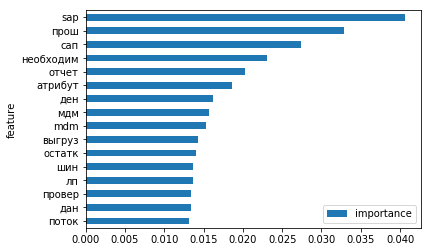

In [184]:
df_feature_importances.set_index('feature')[-16:].plot(kind='barh')